In [1]:
# !pip install mne
import torch
import torch.nn as nn
from torch.nn import functional as F
import glob
import os


import numpy as np
import mne
import torch.optim as optim

In [22]:
B = 3  # batch size
S = 21
C = 120
L = 150
M = L//5  # reduced temporal dimension
num_heads = 5
device='cuda'

In [23]:
def find_files_by_extension(search_pattern):
    edf_files = glob.glob(search_pattern, recursive=True)
    return edf_files

In [24]:
search_pattern = pattern = r"C:\Users\DELL\Downloads\tukl\Implementations\eegformer\dataset_s\*\*\*.edf"
file_paths = find_files_by_extension(search_pattern)

for file_path in file_paths[:9]:
    print(file_path)

In [25]:
import mne
# Open the EDF file
# edf_file = mne.io.read_raw_edf(r'/content/0000002.edf')
edf_file = mne.io.read_raw_edf(r'C:\Users\DELL\Downloads\tukl\Implementations\eegformer\dataset_s\abnormal\eval\0000036.edf')
# Print basic information about the file
print(edf_file.info)
# Plot the raw data
edf_file.plot(duration=3000, n_channels=10)  # Adjust the duration and number of channels as needed


Extracting EDF parameters from /home/arooba/ssd/hira/eegformer_try_2/C:\Users\DELL\Downloads\tukl\Implementations\eegformer\dataset_s\abnormal\eval\0000036.edf...
EDF file detected


FileNotFoundError: [Errno 2] No such file or directory: '/home/arooba/ssd/hira/eegformer_try_2/C:\\Users\\DELL\\Downloads\\tukl\\Implementations\\eegformer\\dataset_s\\abnormal\\eval\\0000036.edf'

In [26]:
import numpy as np
from scipy import signal

def downsample_signal(original_sampling_freq, target_sampling_freq, signal_data):
    original_num_samples = signal_data.shape[1]
    original_time = np.arange(original_num_samples) / original_sampling_freq

    target_num_samples = int(original_num_samples * (target_sampling_freq / original_sampling_freq))
    target_time = np.arange(target_num_samples) / target_sampling_freq

    downsampled_signal = signal.resample(signal_data, target_num_samples, axis=1)

    return downsampled_signal

# Example usage:
original_sampling_freq = 200
target_sampling_freq = 100
eeg_data = edf_file.get_data()

downsampled_eeg_data = downsample_signal(original_sampling_freq, target_sampling_freq, eeg_data)

# Example usage: Print the dimensions of the downsampled EEG data
print("original: ", eeg_data.shape)
print("downsampled: ", downsampled_eeg_data.shape)


NameError: name 'edf_file' is not defined

In [27]:
# Detrend
def detrend_signal(signal_data):
    detrended_signal = signal.detrend(signal_data, axis=1)
    return torch.tensor(detrended_signal, dtype=torch.float64)


detrended_eeg_data = detrend_signal(downsampled_eeg_data)

# Example usage: Print the dimensions of the detrended EEG data
print(detrended_eeg_data.shape)

NameError: name 'downsampled_eeg_data' is not defined

In [28]:
import pandas as pd
path = r"C:\Users\DELL\Downloads\tukl\Implementations\eegformer\dataset_s\new.csv"
def generate_label_ref(path):
    '''generates label ref dictionary from
    the csv file'''
    labels_file_path = path
    # Load the CSV file into a DataFrame
    df = pd.read_csv(labels_file_path)

    paths = df["paths"].tolist()
    labels = df["labels"].tolist()

    label_reference = dict(zip(paths, labels))
    
    return label_reference


label_reference = generate_label_ref(path)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\DELL\\Downloads\\tukl\\Implementations\\eegformer\\dataset_s\\new.csv'

In [ ]:
# import torch
# from torch.utils.data import Dataset, DataLoader

# class TrainDataset(Dataset):
#     def __init__(self, fdeviceile_paths, label_ref transform=None):
#         self.file_paths = file_paths
#         self.transform = transform
#         self.label_reference = label_ref

#     def __len__(self):
#         return len(self.file_paths)

#     def __getitem__(self, idx):
#         file_path = self.file_paths[idx]
#         # Load and preprocess your data here
#         edf_file = mne.io.read_raw_edf(file_path)
#         eeg_data = edf_file.get_data()
#         downsampled_eeg_data = self.downsample_signal(original_sampling_freq, target_sampling_freq, eeg_data)
#         data = self.detrend_signal(downsampled_eeg_data)  # tensor
#         label = label_reference[file_path]

#         return data, label  # Return the preprocessed data and label
    
#     def downsample_signal(self, original_sampling_freq, target_sampling_freq, signal_data):
#         original_num_samples = signal_data.shape[1]
#         original_time = np.arange(original_num_samples) / original_sampling_freq

#         target_num_samples = int(original_num_samples * (target_sampling_freq / original_sampling_freq))
#         target_time = np.arange(target_num_samples) / target_sampling_freq

#         downsampled_signal = signal.resample(signal_data, target_num_samples, axis=1)

#         return downsampled_signal

#     def detrend_signal(self, signal_data):
#         detrended_signal = signal.detrend(signal_data, axis=1)
#         return torch.tensor(detrended_signal, dtype=torch.float64)

# # Example usage:
# file_paths = ['path/to/file1', 'path/to/file2', 'path/to/file3']
# dataset = CustomDataset(file_paths)

# batch_size = 32
# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# # Iterate over the dataset
# for batch_data, batch_labels in dataloader:
#     # Training or evaluation loop
#     # ...



In [ ]:
class TrainDataLoader:
    def __init__(self, search_pattern, label_path):
        self.file_paths = self.find_files_by_extension(search_pattern)
        self.label_reference = self.generate_label_ref(label_path) 

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        # Load and preprocess your data here
        edf_file = mne.io.read_raw_edf(file_path)
        eeg_data = edf_file.get_data()
        downsampled_eeg_data = self.downsample_signal(original_sampling_freq, target_sampling_freq, eeg_data)
        data = self.detrend_signal(downsampled_eeg_data) * 1e6  # tensor
        label = self.label_reference[file_path]

        return data, label  # Return the preprocessed data and label    
    
    def generate_label_ref(self, path):
        '''generates label ref dictionary from
        the csv file'''
        labels_file_path = path
        # Load the CSV file into a DataFrame
        df = pd.read_csv(labels_file_path)

        paths = df["paths"].tolist()
        labels = df["labels"].tolist()

        label_reference = dict(zip(paths, labels))

        return label_reference

    def find_files_by_extension(self, search_pattern):
        edf_files = glob.glob(search_pattern, recursive=True)
        return edf_files  

    def downsample_signal(self, original_sampling_freq, target_sampling_freq, signal_data):
        original_num_samples = signal_data.shape[1]
        original_time = np.arange(original_num_samples) / original_sampling_freq

        target_num_samples = int(original_num_samples * (target_sampling_freq / original_sampling_freq))
        target_time = np.arange(target_num_samples) / target_sampling_freq

        downsampled_signal = signal.resample(signal_data, target_num_samples, axis=1)

        return downsampled_signal

    def detrend_signal(self, signal_data):
        detrended_signal = signal.detrend(signal_data, axis=1)
        return torch.tensor(detrended_signal, dtype=torch.float64)  


In [29]:
dataset = TrainDataLoader(search_pattern, path)

NameError: name 'TrainDataLoader' is not defined

In [30]:
minn = 0
for x, y in dataset:
    if x.shape[1] < minn:
        minn = x.shape[1]
print(minn)

NameError: name 'dataset' is not defined

In [31]:
print(x.shape)

NameError: name 'x' is not defined

In [32]:
print(y)

NameError: name 'y' is not defined

In [33]:
def generate_unsegmented_dataset(file_paths, label_reference):
    xs = [] # list of tensors
    ys = [] # list of numbers

    xs_eval = []
    ys_eval = []

    for file_path in file_paths:
        # do not add eval data to the dataset
        if 'eval' in file_path:
            # if the label for the filepath is present in the reference, only then append label and path to dataset
            try:
                ys_eval.append(label_reference[file_path]) # numbers
            except:
                continue
            edf_file = mne.io.read_raw_edf(file_path)
            eeg_data = edf_file.get_data()
            downsampled_eeg_data = downsample_signal(original_sampling_freq, target_sampling_freq, eeg_data)
            detrended_eeg_data = detrend_signal(downsampled_eeg_data)  # tensor
            xs_eval.append(detrended_eeg_data)
        else:
            # if the label for the filepath is present in the reference, only then append label and path to dataset
            try:
                ys.append(label_reference[file_path]) # numbers
            except:
                continue
            edf_file = mne.io.read_raw_edf(file_path)
            eeg_data = edf_file.get_data()
            downsampled_eeg_data = downsample_signal(original_sampling_freq, target_sampling_freq, eeg_data)
            detrended_eeg_data = detrend_signal(downsampled_eeg_data)  # tensor
            xs.append(detrended_eeg_data)
    
    return xs, ys, xs_eval, ys_eval

In [34]:
X, Y, X_eval, Y_eval = generate_unsegmented_dataset(file_paths, label_reference)


NameError: name 'label_reference' is not defined

In [35]:
def segmented_dataset_builder(xs, ys, xs_eval, ys_eval, segment_length, dim):
    data_X = []
    data_Y = []

    data_X_eval = []
    data_Y_eval = []

    index = 0
    for tensor in xs:
        label = ys[index]
        for i in range(tensor.size(dim) // segment_length):
            start_idx = i * segment_length
            end_idx = start_idx + segment_length

            # Extract the segment
            segment = tensor[:, start_idx:end_idx]

            # Update data arrays
            data_X.append(segment.tolist())
            data_Y.append(label)

    for tensor in xs_eval:
        label = ys_eval[index]
        for i in range(tensor.size(dim) // segment_length):
            start_idx = i * segment_length
            end_idx = start_idx + segment_length

            # Extract the segment
            segment = tensor[:, start_idx:end_idx]

            # Update data arrays
            data_X_eval.append(segment.tolist())
            data_Y_eval.append(label)

        data_X = torch.tensor(data_X)
        data_Y = torch.tensor(data_Y)
        data_X_eval = torch.tensor(data_X_eval)
        data_Y_eval = torch.tensor(data_Y_eval)
        
        return data_X.double(), data_Y.double(), data_X_eval.double(), data_Y_eval.double()
    
data_X, data_Y, data_X_eval, data_Y_eval = segmented_dataset_builder(X, Y, X_eval, Y_eval, 150, 1)            

NameError: name 'X' is not defined

In [36]:
print(data_X.shape)
print(data_Y.shape)
print(data_X_eval.dtype)
print(data_Y_eval.dtype)

NameError: name 'data_X' is not defined

In [37]:
def get_batch(split):
    if split == "train":
        data = data_X
        label = data_Y
    elif split == "eval":
        data = data_X_eval
        label = data_Y_eval

    ix = torch.randint(data.size(0), (B,))
    x = torch.stack([data[i] for i in ix])
    y = torch.stack([label[i] for i in ix])

    return x, y
xb, yb = get_batch('train')

NameError: name 'data_X' is not defined

In [38]:
print(xb.shape, yb.shape)

NameError: name 'xb' is not defined

In [39]:
position_embedding_table = nn.Embedding(L, 1)

In [40]:
a = xb + position_embedding_table(xb.long()).squeeze().double()
print(a.shape)

NameError: name 'xb' is not defined

In [41]:
class CNN1D(nn.Module):
    def __init__(self, S=21, L=150, C=120):
        super().__init__()
        self.S = S  # no. of channels
        self.L = L  # no. of sampled points
        self.C = C  # depth of convolutional dimension
        self.conv_layer_1 = nn.Conv1d(1, C, kernel_size=4)
        self.conv_layer_2 = nn.Conv1d(C, C, kernel_size=4)
        self.conv_layer_3 = nn.Conv1d(C, C, kernel_size=4)
        self.conv_layer_4 = nn.Conv1d(C, C, kernel_size=4)
        self.conv_layer_1.double()  # Update the data type of the convolutional layer weights to torch.float64
        self.conv_layer_2.double()
        self.conv_layer_3.double()
        self.conv_layer_4.double()

    def forward(self, x):
        outputs = []
        for i in range(self.S):
            input_row = x[:, i:i+1, :]  # (batch_size=1, channels=1, length=num_columns)
            output_tensor = self.conv_layer_1(input_row)
            output_tensor = self.conv_layer_2(output_tensor)
            output_tensor = self.conv_layer_3(output_tensor)
            output_tensor = self.conv_layer_4(output_tensor)
            outputs.append(output_tensor.unsqueeze(1))

        output_tensor = torch.cat(outputs, dim=1)
        return output_tensor

# # Get the number of rows and columns
# x = torch.tensor(detrended_eeg_data, dtype=torch.float64)
# num_rows, num_columns = detrended_eeg_data.shape

# # Define the Conv1D layer
# conv1d_layer = CNN1D(S=21, L=L, C=C)
# output = conv1d_layer(xb)

# # Print output shape
# print(output.shape)

In [42]:
def pad_tensor(tensor, dim, length):
    tensor_shape = list(tensor.shape)
    current_length = tensor_shape[dim]

    if current_length >= length:
        return tensor

    padding_shape = tensor_shape.copy()
    padding_shape[dim] = length - current_length

    padding = torch.zeros(padding_shape, dtype=tensor.dtype, device=device)
    padded_tensor = torch.cat((tensor, padding), dim=dim)

    return padded_tensor


In [43]:
output = pad_tensor(torch.rand(3, 4).to('cuda'), 1, L)
print(output.device)

cuda:0


In [44]:
class RegionalHead(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size, C, L):
        # Parameters are head_size(d), no. of tokens(C), and input embedding size(L)
        super().__init__()
        self.block_size = C
        self.n_embed = L
        self.head_size = head_size 
        self.key = nn.Linear(self.n_embed, self.head_size, bias=False).double()
        self.query = nn.Linear(self.n_embed, self.head_size, bias=False).double()
        self.value = nn.Linear(self.n_embed, self.head_size, bias=False).double()
        self.register_buffer('tril', torch.tril(torch.ones(self.block_size, self.block_size)))
        self.dropout = nn.Dropout(0.01)

    def forward(self, x):
        B, S_, C_, L_ = x.shape
        x = x.view(S_, B, C_, L_)  # (B, T, C, L)
        matrices = []

        for spatial_mat in x:
            inp = spatial_mat
            # Below this, T is not the original T, but the head size
            k = self.key(inp)   # (B, C, T)
            q = self.query(inp) # (B, C, T)
            # compute attention scores ("affinities")
            wei = q @ k.transpose(-2,-1) * self.head_size**-0.5 # (B, C, T) @ (B, T, C) -> (B, C, C)
            wei = F.softmax(wei, dim=-1) # (B, C, C)
            wei = self.dropout(wei)
            # perform the weighted aggregation of the values
            v = self.value(inp) # (B, C, T)
            out = wei @ v # (B, C, C) @ (B, C, T) -> (B, C, T)
            matrices.append(out.tolist())

        matrices = torch.tensor(matrices)
        out = matrices.view(B, S_, C_, self.head_size)
        return out.double()

In [45]:
rh = RegionalHead(head_size=L//5, C=C, L=L)
rh_output = rh(torch.rand)  # unsqueeze adds an extra batch dimension
print(rh_output.shape)

AttributeError: 'builtin_function_or_method' object has no attribute 'shape'

In [46]:
class RegionalMultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size, C, L):
        super().__init__()
        self.heads = nn.ModuleList([RegionalHead(head_size, C, L) for _ in range(num_heads)])
        self.proj = nn.Linear(L, L).double()
        self.dropout = nn.Dropout(0.001)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1).to(device)
        # out = self.dropout(self.proj(out)) # Instead of this line, we proceed as below:

        # Implementing projection layer after the multihead attention module
        b, s, c, l = out.shape
        out = out.view(s, b, c, l)

        matrices = []
        for inp in out:
            matrix = self.dropout(self.proj(inp))
            matrices.append(matrix.tolist())

        matrices = torch.tensor(matrices)
        matrices = matrices.view(b, s, c, l).to('cuda')

        return matrices.double()

In [47]:
mrh = RegionalMultiHeadAttention(5, head_size=L//5, C=C, L=L).to('cuda')
mrh_output = mrh(torch.rand(B, S, C, L).double().to('cuda'))
mrh_output.device


device(type='cuda', index=0)

In [48]:
class FeedFowardRegional(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, L): 
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(L, 4*L), 
            nn.ReLU(),
            nn.Linear(4*L, L),
            nn.Dropout(0.001),
        ).double()

    def forward(self, x):
        b, s, c, l = x.shape
        x = x.view(s, b, c, l)

        matrices = []
        for inp in x:
            matrix = self.net(inp)
            matrices.append(matrix.tolist())

        matrices = torch.tensor(matrices).to(device)
        # s_, b_, c_, l_ = matrices.shape
        matrices = matrices.view(b, s, c, l)


        return matrices.double()

In [49]:
ffr = FeedFowardRegional(L).to('cuda')
ffr_output = ffr(torch.rand(B, S, C, L).double().to('cuda'))
print(ffr_output.shape)

torch.Size([3, 21, 120, 150])


In [50]:
class BlockRegional(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, L, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        D = L // n_head
        self.sa = RegionalMultiHeadAttention(n_head, D, C, L)
        self.ffwd = FeedFowardRegional(L)
        self.ln1 = nn.LayerNorm(L).double()
        self.ln2 = nn.LayerNorm(L).double()

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

In [51]:
br = BlockRegional(L, 5).to('cuda')
br_output = br(torch.rand(B, S, C, L).double().to('cuda'))
print(br_output.shape)
print(br_output.device)

torch.Size([3, 21, 120, 150])
cuda:0


In [52]:
def RegionalToSynchronousShapeShifter(tensor):
    b, s, c, l = tensor.shape
    return tensor.view(b, c, s, l)

sync_input = RegionalToSynchronousShapeShifter(br_output)
print(sync_input.shape)
print(sync_input.device)

torch.Size([3, 120, 21, 150])
cuda:0


Output of Regional block: [batch, S, C, L]


Input expected by Synchronous Block: [batch, C, S, L]

In [53]:
class SynchronousHead(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size, S, L):
        # Parameters are head_size(d), no. of tokens(C), and input embedding size(L)
        super().__init__()
        self.block_size = S
        self.n_embed = L
        self.head_size = head_size 
        self.key = nn.Linear(self.n_embed, self.head_size, bias=False).double()
        self.query = nn.Linear(self.n_embed, self.head_size, bias=False).double()
        self.value = nn.Linear(self.n_embed, self.head_size, bias=False).double()
        self.register_buffer('tril', torch.tril(torch.ones(self.block_size, self.block_size)))
        self.dropout = nn.Dropout(0.01)

    def forward(self, x):
        b, c, s, l= x.shape
        x = x.view(c, b, s, l)  # (C, B, S, L)
        matrices = []

        for spatial_mat in x:
            inp = spatial_mat
            k = self.key(inp)   # (B, S, D)
            q = self.query(inp) # (B, S, D)
            # compute attention scores ("affinities")
            wei = q @ k.transpose(-2,-1) * self.head_size**-0.5 # (B, S, D) @ (B, D, S) -> (B, S, S)
            wei = F.softmax(wei, dim=-1) # (B, S, S)
            wei = self.dropout(wei)
            # perform the weighted aggregation of the values
            v = self.value(inp) # (B, S, D)
            out = wei @ v # (B, S, S) @ (B, S, D) -> (B, S, D)
            matrices.append(out.tolist())

        matrices = torch.tensor(matrices)
        out = matrices.view(b, c, s, self.head_size)
        return out.double().to(device)

In [54]:
sh = SynchronousHead(head_size=L//5, S=S, L=L).to('cuda')
sh_output = sh(sync_input) # unsqueeze adds an extra batch dimension
print(sh_output.shape)
print(sh_output.device)

torch.Size([3, 120, 21, 30])
cuda:0


In [55]:
class SynchronousMultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size, S, L):
        super().__init__()
        self.heads = nn.ModuleList([SynchronousHead(head_size, S, L) for _ in range(num_heads)])
        self.proj = nn.Linear(L, L).double()
        self.dropout = nn.Dropout(0.001)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1).to('cuda')
        # out = self.dropout(self.proj(out)) # Instead of this line, we proceed as below:

        # Implementing projection layer after the multihead attention module
        b, c, s, l = out.shape
        out = out.view(c, b, s, l)

        matrices = []
        for inp in out:
            matrix = self.dropout(self.proj(inp))  # inp is (B, S, L)
            matrices.append(matrix.tolist())

        matrices = torch.tensor(matrices)
        matrices = matrices.view(b, c, s, l)

        return matrices.double().to(device)

In [56]:
mhs = SynchronousMultiHeadAttention(5, head_size=L//5, S=S, L=L).to('cuda')
mhs_output = mhs(sync_input)
print(mhs_output.shape)
print(mhs_output.device)

torch.Size([3, 120, 21, 150])
cuda:0


In [57]:
class FeedFowardSync(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, L): 
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(L, 4*L), 
            nn.ReLU(),
            nn.Linear(4*L, L),
            nn.Dropout(0.001),
        ).double()

    def forward(self, x):
        b, c, s, l = x.shape
        x = x.view(c, b, s, l)

        matrices = []
        for inp in x:
            matrix = self.net(inp)
            matrices.append(matrix.tolist())

        matrices = torch.tensor(matrices)
        # s_, b_, c_, l_ = matrices.shape
        matrices = matrices.view(b, c, s, l)


        return matrices.double().to(device)

In [58]:
ffs = FeedFowardSync(L).to(device)
ffs_output = ffs(mhs_output)
print(ffs_output.shape)
print(ffs_output.device)

torch.Size([3, 120, 21, 150])
cuda:0


In [59]:
class BlockSync(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, L, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        D = L // n_head
        self.sa = SynchronousMultiHeadAttention(n_head, D, S, L)
        self.ffwd = FeedFowardSync(L)
        self.ln1 = nn.LayerNorm(L).double()
        self.ln2 = nn.LayerNorm(L).double()

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

In [60]:
bs = BlockSync(L, 5).to('cuda')
bs_output = bs(sync_input)
print(bs_output.shape)
print(bs_output.device)

torch.Size([3, 120, 21, 150])
cuda:0


## Temporal Encoder

In [61]:
class TemporalTransformer(nn.Module):
    def __init__(self, S, C, L, M):
        super(TemporalTransformer, self).__init__()
        self.C = C  # Number of channels
        self.L = L  # Original temporal dimensionality
        self.S = S  # Spatial dimension
        self.M = M  # Compressed dimensionality
        
        self.patch_size = self.C * self.S  # Patch size
        self.M_linear = nn.Linear(self.patch_size, self.patch_size).double()  # Learnable matrix M
        
    def forward(self, z5):
        # z5: (B, C, S, D) input tensor
        # Recuce the temporal dimension to M
        z5_averaged = self.reduce_temporal_dimension(z5, self.M) # (B, C, S, M)
        # Reshape the tensor to B, M, S*C
        z5_reshaped = z5_averaged.reshape(z5.shape[0], -1, self.S*self.C)  # B, M, S*C
        # Get latent vectors out of the current tensor
        latent = self.M_linear(z5_reshaped) # (B, M, S*C)
        return latent
    
    def reduce_temporal_dimension(self, input_tensor, M):
        # input_tensor: (B, C, S, L) input tensor
        # M: Compressed dimensionality

        # Reshape the tensor to 3D
        reshaped_tensor = input_tensor.view(-1, input_tensor.size(2), input_tensor.size(3))  # Shape: (B*C, S, L)

        # Calculate the mean along the last dimension (L)
        averaged_tensor = torch.mean(reshaped_tensor, dim=-1)  # Shape: (B*C, S)

        # Resize the tensor to have the desired compressed dimensionality (M)
        resized_tensor = torch.nn.functional.interpolate(averaged_tensor.unsqueeze(-1), size=M, mode='linear', align_corners=False)
        resized_tensor = resized_tensor.squeeze(-1)

        # Reshape back to 4D
        output_tensor = resized_tensor.view(input_tensor.size(0), input_tensor.size(1), input_tensor.size(2), M)  # Shape: (B, C, S, M)

        return output_tensor


In [62]:
temporal = TemporalTransformer(S, C, L, M=L//5).to(device)  # M is 15 here
print(f'Input: {bs_output.shape}')
temporal_without_attention_output = temporal(bs_output)
print(f'Output: {temporal_without_attention_output.shape}')
print(f'Output device: {temporal_without_attention_output.device}')


Input: torch.Size([3, 120, 21, 150])
Output: torch.Size([3, 30, 2520])
Output device: cuda:0


In [63]:
class HeadTemporal(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size, n_embed):
        super().__init__()
        self.key = nn.Linear(n_embed, head_size, bias=False).double()
        self.query = nn.Linear(n_embed, head_size, bias=False).double()
        self.value = nn.Linear(n_embed, head_size, bias=False).double()

        self.dropout = nn.Dropout(0.01)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out
    
class MultiHeadAttentionTemporal(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size, n_embed):
        super().__init__()
        self.n_embed = n_embed
        self.heads = nn.ModuleList([HeadTemporal(head_size, self.n_embed) for _ in range(num_heads)])
        self.proj = nn.Linear(self.n_embed, self.n_embed).double()
        self.dropout = nn.Dropout(0.01)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFowardTemporal(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(0.001),
        ).double()

    def forward(self, x):
        return self.net(x)

class TemporalBlock(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttentionTemporal(n_head, head_size, n_embd)
        self.ffwd = FeedFowardTemporal(n_embd)
        self.ln1 = nn.LayerNorm(n_embd).double()
        self.ln2 = nn.LayerNorm(n_embd).double()

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

In [64]:
def product_of_2_least_common_factors(num):
    factors = []
    
    # Find all factors of the number
    for i in range(1, num + 1):
        if num % i == 0:
            factors.append(i)
        if len(factors) == 3:
            break
    
    ans = 1
    for factor in factors:
        ans = ans * factor
    
    return ans

product_of_2_least_common_factors(2520)

6

In [65]:
# Till now the shape of tensor is: B, N, D
# We don't want d to decrease, so we need to specify num_of_heads, and head_size carefully
# The product_of_2_least_common_factors function allows us to achieve this.
# It gives us a small number which can be used as the parameter: number of heads, as it's ouput divides d with no remainder
no_of_heads_for_temoral_block = product_of_2_least_common_factors(S*C)
print(no_of_heads_for_temoral_block)
bt = TemporalBlock(S*C, no_of_heads_for_temoral_block).to(device)

6


In [66]:
print(f'Input shape: {temporal_without_attention_output.shape}')
eeg_encoder_output = bt(temporal_without_attention_output)
print(f'Output shape: {eeg_encoder_output.shape}')
print(f'Output shape: {eeg_encoder_output.device}')

Input shape: torch.Size([3, 30, 2520])
Output shape: torch.Size([3, 30, 2520])
Output shape: cuda:0


In [67]:
class Decoder(nn.Module):
    def __init__(self, B, M, S, C):
        super(Decoder, self).__init__()
        self.B = B
        self.M = M
        self.S = S
        self.C = C

        # Define the layers
        # Define the 1D convolutional filter - captures info along the convolutional dimension
        self.l1_filter = nn.Conv1d(M*S, M*S, kernel_size=C).double()
        # Define the l2 filter - captures info along spatial dimension
        self.l2_filter = nn.Conv1d(M, M, kernel_size=S).double()
        # PREDICTION NEURAL NETWORK
        self.layer0 = nn.Linear(M, 256).double()
        self.layer1 = nn.Linear(256, 64).double()
        self.layer2 = nn.Linear(64, 1).double()
        self.leaky_relu = nn.LeakyReLU().double()
        self.sigmoid = nn.Sigmoid().double()

    def forward(self, x):
        x = self.encoder_to_decoder_shape_transition(x)

        # Reshape from (B, M, S, C) to (B, M*S, C)
        x = x.view(self.B, self.M*self.S, self.C)
        # Apply the convolutional filter
        x = self.l1_filter(x)  # reduces C dimension to 1
        # Reshape the output tensor back to the desired shape (B, M, S)
        x = x.view(self.B, self.M, self.S)
        # apply
        x = self.l2_filter(x)  # this filter reduces s dimension to 1
        # Reshape
        b, m, s =  x.shape 
        x = x.view(b, m*s)  # (B, M)
    
        # Pass the input through the layers with activations
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.leaky_relu(x)
        x = self.layer2(x)
        x = self.leaky_relu(x)
        x = self.sigmoid(x)
        return x

    def encoder_to_decoder_shape_transition(self, matrix):
        '''this function reshapes the oupput of encoder so that it is
        suitable for the decoder'''
        matrix = matrix.view(B, M, S, C)
        return matrix

In [68]:
decoder = Decoder(B, M, S, C).to(device)
prediction = decoder(eeg_encoder_output)
print(prediction)

tensor([[0.5082],
        [0.5078],
        [0.5085]], device='cuda:0', dtype=torch.float64,
       grad_fn=<SigmoidBackward0>)


## EEGFormer

In [69]:
class EEGFormer(nn.Module):
    def __init__(self, B, S, C, L, M):
        super().__init__()
        self.B = B
        self.S = S
        self.C = C
        self.L = L
        self.M = M
        self.position_embedding_table = nn.Embedding(L, 1).to(device)
        self.conv1d_layer = CNN1D(S=S, L=L, C=C).to(device)
        self.br = BlockRegional(L, num_heads).to(device)
        self.bs = BlockSync(L, num_heads).to(device)
        self.temporal = TemporalTransformer(S, C, L, M=M) .to(device)
        self.bt = TemporalBlock(S*C, n_head=product_of_2_least_common_factors(S*C)).to(device)  # nembd, nhead
        self.decoder = Decoder(B, M, S, C).to(device)
        self.position_embedding_table = nn.Embedding(L, 1).to(device)

    def forward(self, x, targets=None):
        # x is eeg segment
        x = x + self.position_embedding_table(x.long()).squeeze().double()
        x = self.conv1d_layer(x)
        x = pad_tensor(x, dim=3, length=L)
        x = self.br(x)
        x = RegionalToSynchronousShapeShifter(x)
        x = self.bs(x)
        x = self.temporal(x)
        x = self.bt(x)
        x = self.decoder(x)

        if targets == None:
            loss = None
        else:
            B, cols = x.shape
            probabilities = x.view(B*cols,)
            loss = F.binary_cross_entropy(probabilities, targets)   
                     
        return x, loss

## Training Loop

In [70]:
eval_iters = 1
eval_interval = 3
log_file_path = "loss_log.txt"
max_iters = 6
learning_rate = 0.1
# Create a list to store training and validation losses
train_losses = []
val_losses = []

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'eval']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            probs, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [71]:
torch.cuda.empty_cache()

In [72]:
# Initialize your EEGFormer model
device='cuda'
model = EEGFormer(B, S, C, L, M)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [73]:
inp= torch.rand(B, S,L).to(device)

In [74]:
model(inp)

(tensor([[0.5117],
         [0.5123],
         [0.5116]], device='cuda:0', dtype=torch.float64,
        grad_fn=<SigmoidBackward0>),
 None)

In [63]:
# Training loop
for iter in range(max_iters):
    # Every once in a while, evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        train_loss = losses['train']
        val_loss = losses['eval']
        print(f"Step {iter}: Train Loss {train_loss:.4f}, Val Loss {val_loss:.4f}")

        # Append losses to the lists
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Log the losses to a text file
        with open(log_file_path, "a") as log_file:
            log_file.write(f"Step {iter}: Train Loss {train_loss:.4f}, Val Loss {val_loss:.4f}\n")

    # Sample a batch of data
    xb, yb = get_batch('train')

    # Evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()


Step 0: Train Loss 0.6812, Val Loss 0.6812
Step 3: Train Loss 100.0000, Val Loss 100.0000
Step 5: Train Loss 100.0000, Val Loss 100.0000


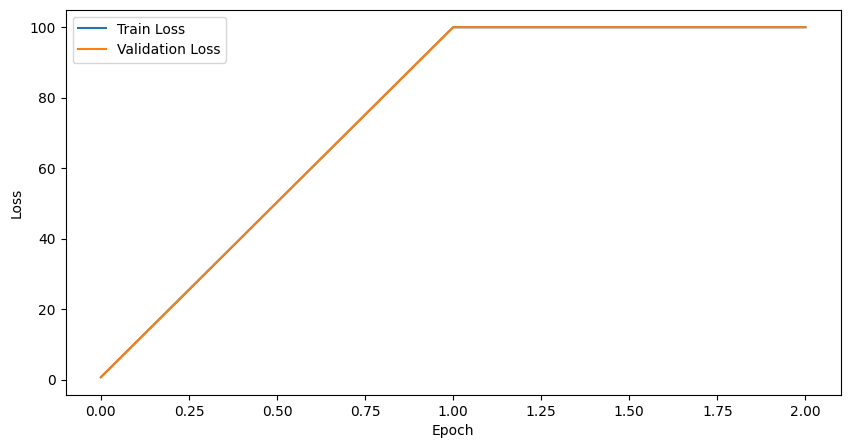

In [67]:
# Visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()